In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

In [3]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01',actions=False)
data.drop(['Open','High','Low','Volume'], inplace= True, axis=1)
data= data.droplevel(0,axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_15086/2938064081.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data= data.droplevel(0,axis=1).resample('M').last()


In [4]:
rets= data.pct_change().fillna(0)
pal=sns.color_palette('Spectral',len(tickers))

##  MDP (Most Diversified PF)

In [10]:
cov = np.array(rets.cov()*12)
vol = np.diag(cov)
noa = rets.shape[1]
init_guess = np.repeat(1/noa,noa)
bounds = ((0.0,1.0),)*noa

#constriant
weights_sum_to_1 = {'type':'eq',
                    'fun': lambda weights: np.sum(weights)-1}

# objective func : negative diversification ratio
def neg_div_ratio(weights,vol,cov):
    weighted_vol = weights.T @ vol
    port_vol = np.sqrt(weights.T @ cov @ weights)
    return -weighted_vol / port_vol

#optimize
res = minimize(neg_div_ratio,
               init_guess,
               args=(vol,cov),
               method ='SLSQP',
               constraints=(weights_sum_to_1),
               bounds=bounds)
weights = res.x
weights

array([0.00000000e+00, 5.24525753e-01, 0.00000000e+00, 2.67465350e-18,
       1.31953472e-01, 0.00000000e+00, 3.43520774e-01, 1.27108998e-17,
       2.18921190e-17])

In [11]:
weights_df = pd.Series(np.round(weights, 4), index=tickers)
weights_df = weights_df[weights_df > 0]


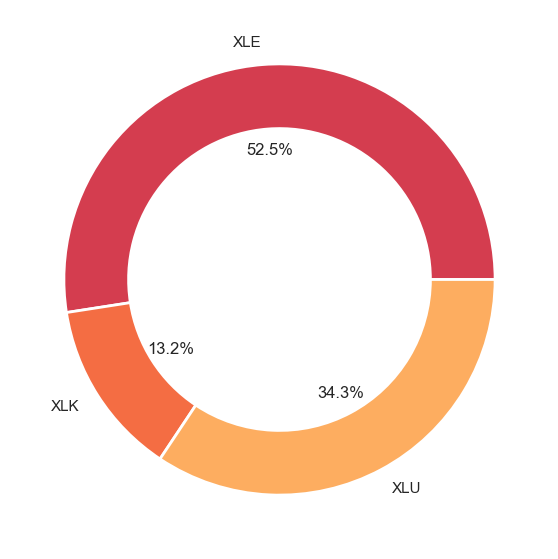

In [12]:
plt.figure(figsize=(7, 7))
wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [13]:
def get_mdp_weights(cov):
    vol = np.diag(cov)
    noa = cov.shape[0]
    init_guess = np.repeat(1/noa, noa)
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}
    def neg_div_ratio(weights, vol, cov):
        weighted_vol = weights.T @ vol
        port_vol = np.sqrt(weights.T @ cov @ weights)
        return - weighted_vol / port_vol

    # 최적화 수행
    res = minimize(neg_div_ratio,
                   init_guess,
                   args=(vol, cov),
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)
    
    return res.x

In [14]:
mdp_w_df = pd.DataFrame().reindex_like(rets)

cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

for i in range(12, len(mdp_w_df)):
    mdp_w_df.iloc[i] = get_mdp_weights(cov[i-1])

Text(0, 0.5, 'Weights')

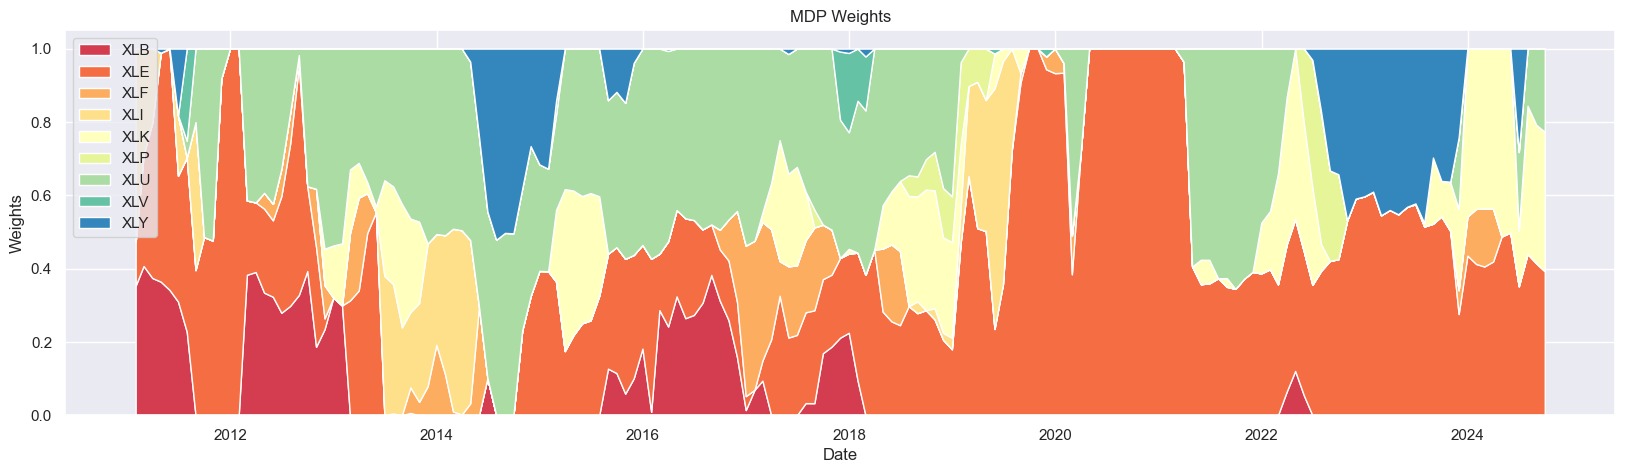

In [16]:
plt.figure(figsize=(20, 5))
plt.stackplot(mdp_w_df.index, mdp_w_df.T, labels=mdp_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('MDP Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Text(0, 0.5, 'Returns')

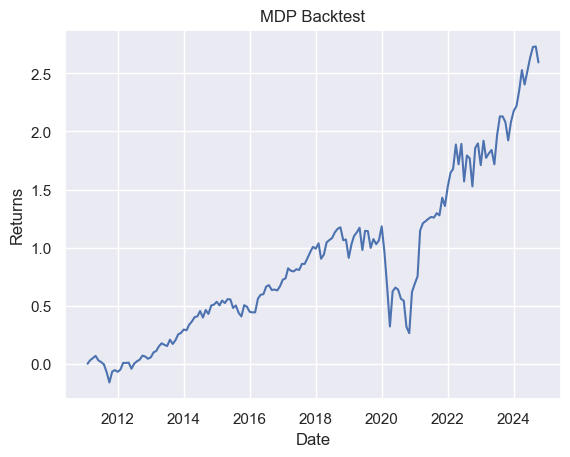

In [17]:
port_rets = mdp_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

plt.plot(port_cum_rets.iloc[12:])
plt.title('MDP Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')